In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.impute import SimpleImputer
from scipy.stats.mstats import winsorize
from dateutil.relativedelta import relativedelta


In [ ]:
# 1. Cargar los datos
trtest = pd.read_csv('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv')
oot = pd.read_csv('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/prueba_op_base_pivot_var_rpta_alt_enmascarado_oot.csv')
prob_hist = pd.read_csv('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/prueba_op_probabilidad_oblig_base_hist_enmascarado_completa.csv')
master = pd.read_csv('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/prueba_op_master_customer_data_enmascarado_completa.csv')
sample_sub = pd.read_csv('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/sample_submission.csv')


In [ ]:
# 2. Mostrar dimensiones de cada set
shapes = pd.DataFrame({
    'Dataset': ['trtest', 'oot', 'prob_hist', 'master', 'sample_submission'],
    'Rows': [trtest.shape[0], oot.shape[0], prob_hist.shape[0], master.shape[0], sample_sub.shape[0]],
    'Columns': [trtest.shape[1], oot.shape[1], prob_hist.shape[1], master.shape[1], sample_sub.shape[1]]
})
print("Dimensiones de los datasets:")
display(shapes)

# 3. Inspección de columnas y primeras filas de trtest y master
print("\nColumnas de trtest:")
print(trtest.columns.tolist())
print("\nPrimeras 5 filas de trtest:")
display(trtest.head())

print("\nColumnas de master:")
print(master.columns.tolist())
print("\nPrimeras 5 filas de master:")
display(master.head())

# 4. Construir diccionario de variables desde Metadata.xlsx
meta_dfs = pd.read_excel('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/Metadata.xlsx', sheet_name=None)
entries = []
for sheet, df in meta_dfs.items():
    var_col, desc_col = df.columns[:2]
    temp = df[[var_col, desc_col]].rename(columns={var_col: 'variable', desc_col: 'description'}).copy()
    temp['sheet'] = sheet
    entries.append(temp)
variable_dict = pd.concat(entries, ignore_index=True)

print("\nDiccionario de Variables (primeras 50 filas):")
display(variable_dict.head(50))



Dimensiones de los datasets:


,Dataset,Rows,Columns
0,trtest,568251,49
1,oot,112549,4
2,prob_hist,4804836,7
3,master,430000,37
4,sample_submission,112549,2



Columnas de trtest:
['nit_enmascarado', 'num_oblig_orig_enmascarado', 'num_oblig_enmascarado', 'fecha_var_rpta_alt', 'var_rpta_alt', 'tipo_var_rpta_alt', 'banca', 'segmento', 'producto', 'producto_cons', 'aplicativo', 'min_mora', 'max_mora', 'dias_mora_fin', 'rango_mora', 'vlr_obligacion', 'vlr_vencido', 'saldo_capital', 'endeudamiento', 'desc_alternativa1', 'desc_alternativa2', 'desc_alternativa3', 'cant_alter_posibles', 'alter_posible1_2', 'alter_posible2_2', 'alter_posible3_2', 'cant_gestiones', 'cant_gestiones_binario', 'rpc', 'promesas_cumplidas', 'cant_promesas_cumplidas_binario', 'cant_acuerdo', 'cant_acuerdo_binario', 'descripcion_ranking_mejor_ult', 'descripcion_ranking_post_ult', 'marca_alt_rank', 'marca_alt_apli', 'valor_cuota_mes', 'pago_cuota', 'porc_pago_cuota', 'pago_mes', 'porc_pago_mes', 'pagos_tanque', 'marca_debito_mora', 'alternativa_aplicada_agr', 'marca_agrupada_rgo', 'marca_pago', 'marca_alternativa', 'marca_alternativa_orig']

Primeras 5 filas de trtest:


,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,var_rpta_alt,tipo_var_rpta_alt,banca,segmento,producto,producto_cons,...,porc_pago_cuota,pago_mes,porc_pago_mes,pagos_tanque,marca_debito_mora,alternativa_aplicada_agr,marca_agrupada_rgo,marca_pago,marca_alternativa,marca_alternativa_orig
0,630611,219718,863073,202308,1,a_uno_tipo_1,Banca Personas,Personal,TARJETA DE CREDITO,Tarjeta de Credito,...,0.095438,0.0,0.000000,Sin pago,NO,CONSOLIDACION,REESTRUCTURACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa
1,59412,789567,290775,202312,1,a_uno_tipo_1,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,...,0.000000,0.0,NaN,Sin pago,NO,PRORROGA,MANTENIMIENTO,Sin pago,Acepta Alternativa,Acepta Alternativa
2,277595,1045909,34433,202312,1,b_uno_tipo_2,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,...,0.000000,0.0,NaN,Sin pago,NO,NaN,NaN,Sin pago,Acepta Alternativa,Acepta Alternativa
3,26897,585786,494556,202311,1,a_uno_tipo_1,Banca Personas,Personal,ROTATIVOS,Rotativos,...,0.042117,4090.0,0.015324,Con pago,NO,PRORROGA,MANTENIMIENTO,Pago parcial,Acepta Alternativa,Acepta Alternativa
4,24588,1061389,18953,202311,1,b_uno_tipo_2,Banca Personas,Personal plus,ROTATIVOS,Rotativos,...,0.000000,0.0,0.000000,Sin pago,NO,CONSOLIDACION,REESTRUCTURACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa



Columnas de master:
['nit_enmascarado', 'cod_tipo_doc', 'tipo_cli', 'ctrl_terc', 'genero_cli', 'ano_nac_cli', 'edad_cli', 'estado_civil', 'tipo_vivienda', 'num_hijos', 'personas_dependientes', 'nivel_academico', 'ocup', 'act_econom', 'sector', 'subsector', 'declarante', 'total_ing', 'tot_activos', 'tot_pasivos', 'origen_fondos', 'f_vinc', 'f_ult_mantenimiento', 'canal_actualizacion', 'cli_actualizado', 'segm', 'subsegm', 'nicho', 'region_of', 'nombre_dpto_dirp', 'egresos_mes', 'tot_patrimonio', 'ciiu', 'smmlv', 'year', 'month', 'ingestion_day']

Primeras 5 filas de master:


,nit_enmascarado,cod_tipo_doc,tipo_cli,ctrl_terc,genero_cli,ano_nac_cli,edad_cli,estado_civil,tipo_vivienda,num_hijos,...,nicho,region_of,nombre_dpto_dirp,egresos_mes,tot_patrimonio,ciiu,smmlv,year,month,ingestion_day
0,536377,1,PERSONA NATURAL,CLIENTE,F,1998.0,25.0,SOLTERO,FAMILIAR,0.0,...,MUJERES,CENTRO,SANTANDER,0.0,33750000.0,NaN,1160000.0,2023,12,31
1,512257,1,PERSONA NATURAL,CLIENTE,F,1984.0,38.0,UNION LIBRE,PROPIA,0.0,...,MUJERES,CARIBE,MAGDALENA,250000.0,5000000.0,ASALARIADOS,1160000.0,2023,9,30
2,5788,1,PERSONA NATURAL,CLIENTE SOCIAL,M,1960.0,63.0,NaN,NaN,0.0,...,NaN,DIRECCIÓN GENERAL,SIN INFORMACION,0.0,0.0,ASALARIADOS,1160000.0,2023,11,30
3,132245,1,PERSONA NATURAL,CLIENTE,F,1982.0,41.0,CASADO,NaN,1.0,...,MUJERES,SUR,VALLE,1000000.0,62513000.0,ASALARIADOS,1160000.0,2023,7,31
4,245279,1,PERSONA NATURAL,CLIENTE,M,1980.0,43.0,CASADO,ALQUILADA,0.0,...,NaN,BOGOTA Y CUNDINAMARCA,CALDAS,1000000.0,34135000.0,ASALARIADOS,1160000.0,2023,12,31



Diccionario de Variables (primeras 50 filas):


,variable,description,sheet
0,nit_enmascarado,bigint,base_pivot_var_rpta_alt_enmasca
1,num_oblig_orig_enmascarado,bigint,base_pivot_var_rpta_alt_enmasca
2,num_oblig_enmascarado,bigint,base_pivot_var_rpta_alt_enmasca
3,fecha_var_rpta_alt,bigint,base_pivot_var_rpta_alt_enmasca
4,var_rpta_alt,tinyint,base_pivot_var_rpta_alt_enmasca
5,tipo_var_rpta_alt,string,base_pivot_var_rpta_alt_enmasca
6,banca,string,base_pivot_var_rpta_alt_enmasca
7,segmento,string,base_pivot_var_rpta_alt_enmasca
8,producto,string,base_pivot_var_rpta_alt_enmasca
9,producto_cons,string,base_pivot_var_rpta_alt_enmasca


In [14]:
# Mostrar los nombres exactos de las columnas de prob_hist
print(prob_hist.columns.tolist())


['nit_enmascarado', 'num_oblig_enmascarado', 'fecha_corte', 'lote', 'prob_propension', 'prob_alrt_temprana', 'prob_auto_cura']


Top 20 variables con más nulos:
 tipo_vivienda            0.920356
nivel_academico          0.891119
nicho                    0.886555
canal_actualizacion      0.783721
estado_civil             0.778446
subsector                0.775897
ciiu                     0.775897
sector                   0.775897
act_econom               0.775119
ocup                     0.772768
subsegm                  0.767393
genero_cli               0.766170
personas_dependientes    0.766160
edad_cli                 0.766158
num_hijos                0.766158
ano_nac_cli              0.766158
origen_fondos            0.762635
nombre_dpto_dirp         0.760813
declarante               0.760187
egresos_mes              0.760097
dtype: float64

Conteo de tipos de datos:
 object     44
float64    30
int64      15
Name: count, dtype: int64

Distribución de var_rpta_alt:
 var_rpta_alt
0    0.519987
1    0.480013
Name: proportion, dtype: float64


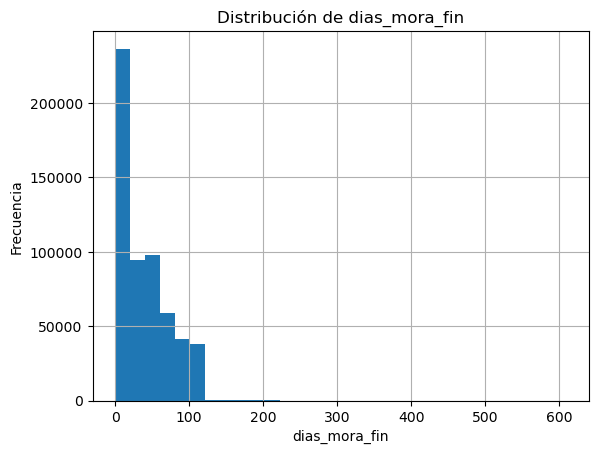

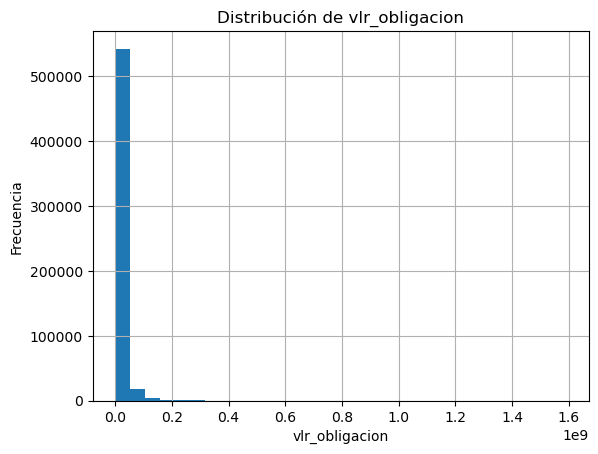

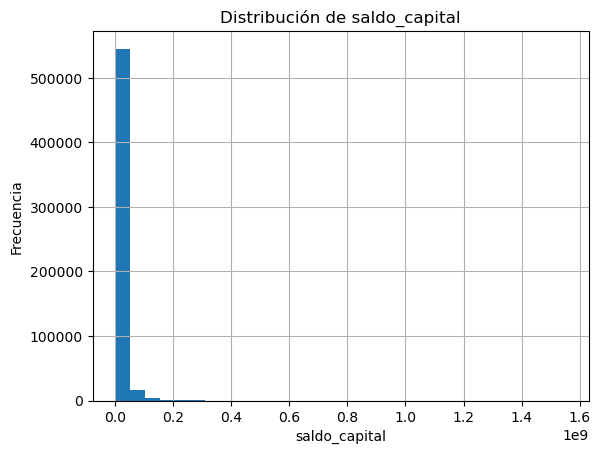

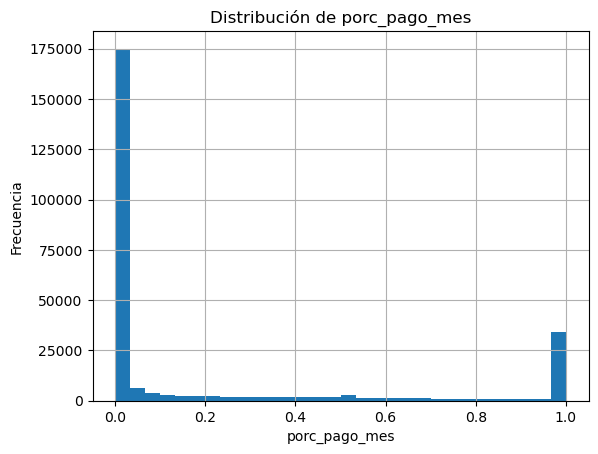

In [18]:
# 2. Agregar probabilidades históricas al nivel cliente–obligación–mes
prob_agg = (
    prob_hist
    .groupby([
        'nit_enmascarado',
        'num_oblig_enmascarado',
        'fecha_corte'
    ])
    .agg(
        prob_propension   = ('prob_propension',   'mean'),
        prob_alrt_temprana= ('prob_alrt_temprana','mean'),
        prob_auto_cura    = ('prob_auto_cura',    'mean')
    )
    .reset_index()
)

# 3. Merge con trtest (LEFT para no perder filas sin histórico)
df = trtest.merge(
    prob_agg,
    left_on=['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_alt'],
    right_on=['nit_enmascarado','num_oblig_enmascarado','fecha_corte'],
    how='left'
)

# 4. Extraer year/month de la variable de fecha (YYYYMM)
df['year']  = df['fecha_var_rpta_alt'] // 100
df['month'] = df['fecha_var_rpta_alt'] % 100

# 5. Merge con datos maestros de cliente según año y mes
df = df.merge(
    master,
    on=['nit_enmascarado','year','month'],
    how='left'
)

# 6. Inspección de calidad de datos
#   a) % de nulos por variable
null_pct = df.isna().mean().sort_values(ascending=False)
print("Top 20 variables con más nulos:\n", null_pct.head(20))

#   b) Tipos de datos
print("\nConteo de tipos de datos:\n", df.dtypes.value_counts())

#   c) Balance de la variable objetivo
print("\nDistribución de var_rpta_alt:\n", df['var_rpta_alt'].value_counts(normalize=True))

# 7. Histogramas de muestra para variables numéricas
num_vars = ['dias_mora_fin','vlr_obligacion','saldo_capital','porc_pago_mes']
for v in num_vars:
    plt.figure()
    df[v].hist(bins=30)
    plt.title(f'Distribución de {v}')
    plt.xlabel(v)
    plt.ylabel('Frecuencia')
    plt.show()


In [ ]:
# Corte de variables con alto nivel de nulos
thresh = 0.75
to_drop = null_pct[null_pct > thresh].index.tolist()
df = df.drop(columns=to_drop)


In [21]:
# Imputacion de variables

# Numéricos
num_cols = df.select_dtypes(float).columns
imp_num = SimpleImputer(strategy='median')
df[num_cols] = imp_num.fit_transform(df[num_cols])

# Categóricos
cat_cols = df.select_dtypes(object).columns
imp_cat = SimpleImputer(strategy='constant', fill_value='SinInfo')
df[cat_cols] = imp_cat.fit_transform(df[cat_cols])


In [25]:
# Deteccion y remocion de valores atipicos
for col in ['vlr_obligacion','saldo_capital','porc_pago_mes','dias_mora_fin']:
    df[col] = winsorize(df[col], limits=[0.03, 0.03])  # recorta 3% en cada cola


In [32]:
hist

,nit_enmascarado,num_oblig_enmascarado,fecha_corte,producto,aplicativo,segmento,valor_cuota_mes,pago_total,fecha_pago_minima,fecha_pago_maxima,porc_pago,marca_pago,ajustes_banco
0,482906,362297,2023-07-31,CARTERA MICROCREDITO,L,MICROPYME,311950.0,1862788.0,20230621.0,20230721.0,597.0,PAGO_MENOS,NO
1,121735,186855,2023-02-28,LIBRE INVERSION,L,SOCIAL,131030.0,264157.0,20230127.0,20230207.0,202.0,PAGO_MENOS,NO
2,582719,675503,2023-10-31,TARJETA DE CREDITO,K,PERSONAL,1405339.0,3320.0,20231003.0,20231003.0,0.0,PAGO_MENOS,NO
3,299903,107931,2023-02-28,ROTATIVOS,L,PERSONAL PLUS,19220.0,0.0,NaN,NaN,0.0,FACTURACION_MES_SGTE,NO
4,88625,566060,2023-04-30,ROTATIVOS,L,PERSONAL,384684.0,769368.0,20230403.0,20230403.0,200.0,PAGO_MAS,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855030,428347,628599,2023-11-30,TARJETA DE CREDITO,K,PERSONAL,320992.0,640523.0,20231120.0,20231120.0,200.0,FACTURACION_MES_SGTE,NO
4855031,356568,606593,2023-02-28,HIPOTECARIO VIVIENDA,4,PERSONAL,814754.0,2308770.0,20230201.0,20230201.0,283.0,PAGO_MAS,NO
4855032,234904,500584,2023-09-30,LIBRE INVERSION,L,PERSONAL,315738.0,0.0,NaN,NaN,0.0,IGUAL,NO
4855033,447934,12846,2023-12-31,LIBRE INVERSION,L,PERSONAL PLUS,5317285.0,89289.0,20231108.0,20231108.0,2.0,PAGO_MENOS,NO


In [ ]:

# 1) Carga tu histórico de cuotas/pagos
hist = pd.read_csv(
    'C:/Users/boris/OneDrive/Desktop/Coding/Test/data/prueba_op_maestra_cuotas_pagos_mes_hist_enmascarado_completa.csv'
)

# 2) Convierte correctamente a datetime (YYYYMMDD)
hist['fecha_corte'] = pd.to_datetime(
    hist['fecha_corte'].astype(str),
    format='%Y%m%d'
)

# 3) Ordena por cliente–obligación–fecha
hist = hist.sort_values([
    'nit_enmascarado',
    'num_oblig_enmascarado',
    'fecha_corte'
])

# 4) Rolling windows de 3 y 6 períodos (meses) para valor_cuota_mes y pago_total
def compute_rolling(df_group, window):
    roll = (
        df_group
        .set_index('fecha_corte')
        .groupby(['nit_enmascarado','num_oblig_enmascarado'])[['valor_cuota_mes','pago_total']]
        .rolling(window=window, min_periods=1)
        .agg(['sum','mean'])
    )
    roll.columns = [f"{col[0]}_{col[1]}_r{window}" for col in roll.columns]
    return roll.reset_index()

roll3 = compute_rolling(hist, 3)
roll6 = compute_rolling(hist, 6)

# 5) Junta ambos rolls
roll_feats = roll3.merge(
    roll6,
    on=['nit_enmascarado','num_oblig_enmascarado','fecha_corte'],
    how='left'
)

# 6) Prepara year/month para el merge con tu df principal
roll_feats['year']  = roll_feats['fecha_corte'].dt.year
roll_feats['month'] = roll_feats['fecha_corte'].dt.month

# 7) Carga y prepara tu df principal
df = pd.read_csv(
    'C:/Users/boris/OneDrive/Desktop/Coding/Test/data/prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv'
)
df['year']  = df['fecha_var_rpta_alt'] // 100
df['month'] = df['fecha_var_rpta_alt'] % 100

# 8) Merge de features rolling
df = df.merge(
    roll_feats.drop(columns=['fecha_corte']),
    on=['nit_enmascarado','num_oblig_enmascarado','year','month'],
    how='left'
)

# 9) Verifica que llegaron columnas *_r3 y *_r6
print([c for c in df.columns if '_r3' in c or '_r6' in c])
print(df[[c for c in df.columns if '_r3' in c or '_r6' in c]].head())
